# VideoLLaMA3 Inference Recipes

## Section 2: Multi Image Understanding

We here show the best recipes to understand multi images with VideoLLaMA3. 


### [General] Load Model and Processor

Loading the model requires approximately 15,967 MB of VRAM at BFloat16 precision. To ensure that only one GPU is used, we restrict the CUDA visible devices to GPU 0 in this example code.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from PIL import Image
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

import torch
from transformers import AutoModelForCausalLM, AutoProcessor, AutoModel, AutoImageProcessor

model_path = "DAMO-NLP-SG/VideoLLaMA3-7B-Image"
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    trust_remote_code=True,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
)
processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True)

/opt/lepton/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


#### Example Images

Load images and display:

image1


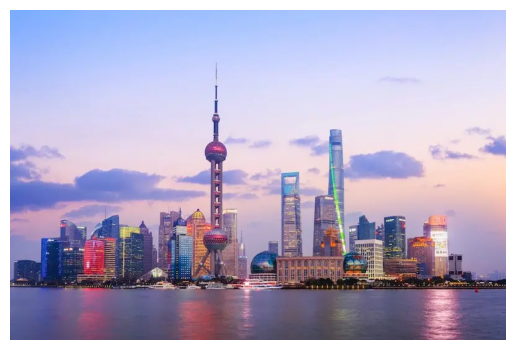

image2


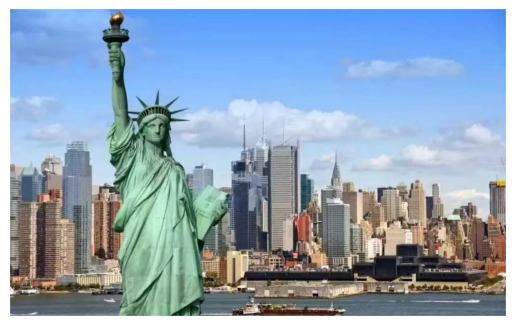

In [3]:
image_path1 = "visuals/city1.jpg"
image1 = Image.open(image_path1).convert("RGB")

print('image1')
plt.imshow(image1)
plt.axis('off')
plt.show()

image_path2 = "visuals/city2.jpg"
image2 = Image.open(image_path2).convert("RGB")

print('image2')
plt.imshow(image2)
plt.axis('off')
plt.show()

Generally, for multi images, the input message for VideoLLaMA3 looks like:

In [4]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Image1: "},
            {"type": "image", "image": {"image_path": image_path1}},
            {"type": "text", "text": "Image2: "},
            {"type": "image", "image": {"image_path": image_path2}},
            {"type": "text", "text": "Are the two images in the same city?"},
        ]
    }
]

Generate corresponding answer:

In [5]:
inputs = processor(conversation=conversation, return_tensors="pt")
inputs = {k: v.cuda() if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
if "pixel_values" in inputs:
    inputs["pixel_values"] = inputs["pixel_values"].to(torch.bfloat16)

output_ids = model.generate(**inputs, max_new_tokens=256)
response = processor.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
print(response)

No, the two images are not in the same city. The first image shows a skyline with a distinctive tall tower and colorful skyscrapers, which appears to be Shanghai's famous Pudong district. The second image features the Statue of Liberty with New York City's skyline in the background. These are two major cities in different countries - Shanghai in China and New York City in the United States.
